In [1]:
%matplotlib inline

import time
import functools
import pandas as pd
import numpy as np
import string
import html
import h5py
import matplotlib.pyplot as plt

import scipy.sparse as sparse

import my_utils

import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords as sw

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

/Users/jiawei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Pipeline

![Pipeline](pipeline.png)

## 1. Load dataset

In [2]:
# Load csv file into DataFrame
kindle_data = pd.read_csv('sampled_data.csv')
type(kindle_data)

pandas.core.frame.DataFrame

In [3]:
# Print first row
# Format: data_frame.col_name[row]
print("overall    :", kindle_data.overall[0])
print("reviewText :", kindle_data.reviewText[0])

overall    : pos
reviewText : This book ended even before it started and it made me want for more. Oh oh such a teaser. I want the book now please. So exciting.


In [4]:
# Length of kindle_data
len(kindle_data)

126871

In [5]:
# Get a sample (head) of the data frame
kindle_data.head()

,overall,reviewText
0,pos,This book ended even before it started and it ...
1,pos,This is a great read with so much emotion you ...
2,pos,"It&#8217;s Christmas Eve and miraculously, Sal..."
3,pos,I enjoyed meeting the character of Cassandra. ...
4,pos,"Can I be the next Hunter wife? Again, I have ..."


In [6]:
# Statics on tags
kindle_data.overall.value_counts()

pos    64559
neg    62312
Name: overall, dtype: int64

This is a balaned binary classification problem, since there are almost the same number of postive and negative reviews. 

In [7]:
# Split complete data set into [pos, neg]
def splitPosNeg(data_):
    neg = data_.loc[data_.overall=='neg']
    pos = data_.loc[data_.overall=='pos']
    return [pos,neg]

[pos,neg] = splitPosNeg(kindle_data)

In [8]:
print(type(pos))
print("pos:", len(pos), ", neg:", len(neg))

<class 'pandas.core.frame.DataFrame'>
pos: 64559 , neg: 62312


## 2. Preprocessing

In [9]:
stopwords = sw.words('english')
stopwords = stopwords + ['not_' + w for w in stopwords]
lemmatizer = WordNetLemmatizer()

In [10]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [11]:
# Translation for punctuations
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
# Example on how maketrans works
transtbl = str.maketrans('abc','def')
'ababc'.translate(transtbl)

'dedef'

In [14]:
def preprocessing(line: str) -> str:
    line = html.unescape(str(line))
    line = str(line).replace("can't", "cann't")
    line = word_tokenize(line.lower())
    
    tokens = []
    negated = False
    for t in line:
        if t in ['not', "n't", 'no']:
            negated = not negated
        elif t in string.punctuation or not t.isalpha():
            negated = False
        else:
            tokens.append('not_' + t if negated else t)
    
    tokens = [lemmatizer.lemmatize(t, 'v') for t in tokens if t not in stopwords]
        
    return ' '.join(tokens)

In [15]:
# Examples of proprocessing results
preprocessing("I can't beleive he wouldn't do that... He's really freaking me out.")

'not_beleive not_would really freak'

In [16]:
test_str = "I bought it yesterday and I really love it!"
preprocessing(test_str)

'buy yesterday really love'

In [17]:
pos_data = []
n_pos = len(pos)
for i, p in enumerate(pos['reviewText']):
    pos_data.append(preprocessing(p))
    my_utils.print_progress(bar_length=50, decimals=0, iteration=i + 1, total=n_pos, prefix='Preprocessing pos data: ')

Preprocessing pos data:  |==================================================| 100% 

In [18]:
neg_data = []
n_neg = len(neg)
for i, n in enumerate(neg['reviewText']):
    neg_data.append(preprocessing(n))
    my_utils.print_progress(bar_length=50, decimals=0, iteration=i+1, total=n_neg, prefix='Preprocessing neg data: ')

Preprocessing neg data:  |==================================================| 100% 


In [19]:
data = pos_data + neg_data
labels = np.concatenate((pos['overall'].values,neg['overall'].values))

### Split Training Data & Test Data

In [20]:
# Split data into training set and testing set (80:20)
# stratify: make sure pos/neg remains the same in training set and testing set
train_data, test_data, train_y, test_y = \
train_test_split(
    data, 
    labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=1234
)

In [21]:
print("training size = ", len(train_data), ", testing size = ", len(test_data))

training size =  101496 , testing size =  25375


In [22]:
# Push all tokens and compute frequency of words
tokens = [word for line in train_data \
               for word in nltk.word_tokenize(line)]

word_features = nltk.FreqDist(tokens)

In [23]:
print(word_features)

<FreqDist with 96226 samples and 3975113 outcomes>


In [24]:
word_features.most_common(10)

[('book', 109061),
 ('read', 64212),
 ('story', 47846),
 ('like', 33733),
 ('love', 33064),
 ('one', 29956),
 ('get', 28632),
 ('character', 27374),
 ('would', 26876),
 ('good', 25987)]

### Find best \# of features

Find best number of top words as features to use.

In [25]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    topwords = [fpair[0] for fpair in list(word_features.most_common(n))]
    
    if tfidf:
        vec = TfidfVectorizer()
    else:
        vec = CountVectorizer()
        
    vec.fit(topwords)
    
    # Generate feature vectors
    train_X = vec.transform(train_data)
    test_X  = vec.transform(test_data)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_X, train_y)
    
    # Test predict
    pred = mnb_model.predict(test_X)
    
    return accuracy_score(pred, test_y), mnb_model

In [26]:
train_with_n_topwords(5000, tfidf=True)

(0.8284137931034483,
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))

In [27]:
possible_n = [5000 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []
for i, n in enumerate(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    my_utils.print_progress(bar_length=50, decimals=0, iteration=2 * i + 1, total=2*len(possible_n), prefix='Train and verify:')
    
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])
    my_utils.print_progress(bar_length=50, decimals=0, iteration=2 * i + 2, total=2*len(possible_n), prefix='Train and verify:')

Train and verify: |==================================================| 100% 


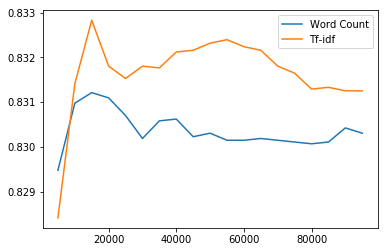

In [28]:
%matplotlib inline
plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
plt.legend()

From the above figure, the largest accuracy achives when there are 15000 top words for this problem.

In [29]:
topwords = [fpair[0] for fpair in list(word_features.most_common(15000))]

## 3. Feature Extraction

In [30]:
tf_vec = TfidfVectorizer()
tf_fit = tf_vec.fit_transform([' '.join(topwords)])
tf_fit

<1x14981 sparse matrix of type '<class 'numpy.float64'>'
	with 14981 stored elements in Compressed Sparse Row format>

In [31]:
# Extract features from training set
# Vocabulary is from topwords
train_features = tf_vec.transform(train_data)

In [32]:
# Array[n_train_data * n_features]
train_features.shape

(101496, 14981)

In [33]:
# Extract features from test set
test_features = tf_vec.transform(test_data)

In [34]:
# (Uni+Bi)-Gram
bg_tf_vec = TfidfVectorizer(ngram_range=(1,2))
bg_tf_vec.fit([' '.join(topwords)])
bg_train_features = bg_tf_vec.transform(train_data)

bg_train_features.shape

# Array[n_train_data * (uni_gram_features + bi_gram_features)]

(101496, 29961)

In [35]:
# Extract (uni+bi)-gram test features
bg_test_features = bg_tf_vec.transform(test_data)

## 4. Models

### Multinomial NB

The multinomial Naive Bayes classifier is suitable for **classification with discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [36]:
from sklearn.naive_bayes import MultinomialNB

In [37]:
mnb_model = MultinomialNB()
mnb_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
# Train Model
start = time.time()
mnb_model.fit(train_features, train_y)
end = time.time()

print("Multinomial NB model trained in %f seconds" % (end-start))

Multinomial NB model trained in 0.274575 seconds


In [39]:
# Predict
pred = mnb_model.predict(test_features)
print(pred)

['neg' 'pos' 'neg' ... 'neg' 'pos' 'neg']


In [40]:
# Metrics
# metrics.accuracy_score(y_true, y_pred)
accuracy = accuracy_score(pred,test_y)
print(accuracy)

0.8328275862068966


In [41]:
# Use keyword arguments to set arguments explicitly
print(classification_report(y_true=test_y, y_pred=pred))

             precision    recall  f1-score   support

        neg       0.85      0.80      0.82     12463
        pos       0.82      0.86      0.84     12912

avg / total       0.83      0.83      0.83     25375



#### Train & test using Uni-Gram + Bi-Gram features

In [42]:
# Train & test using (uni+bi)-gram features
bg_mnb_model = MultinomialNB()
bg_mnb_model.fit(bg_train_features, train_y)
bg_pred = bg_mnb_model.predict(bg_test_features)
print(bg_pred)

['neg' 'pos' 'neg' ... 'neg' 'pos' 'neg']


In [43]:
# Statistics
bg_accuracy = accuracy_score(bg_pred,test_y)
print(bg_accuracy)

0.8323940886699508


In [44]:
print(classification_report(y_true=test_y, y_pred=bg_pred))

             precision    recall  f1-score   support

        neg       0.85      0.80      0.82     12463
        pos       0.82      0.87      0.84     12912

avg / total       0.83      0.83      0.83     25375



Uni-Gram or Bi-Gram do not affect the classifcation result here. 

### Linear SVM

In [45]:
from sklearn.svm import LinearSVC

svc_model = LinearSVC()
print(svc_model, end='\n'*2)

start = time.time()
svc_model.fit(train_features, train_y)
end = time.time()
print('SVC model trained in: %.2fs' % (end - start), end='\n'*2)
svc_pred = svc_model.predict(test_features)

print('Accuracy = %.6f' % accuracy_score(svc_pred, test_y))
print(classification_report(y_pred=svc_pred, y_true=test_y))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

SVC model trained in: 2.09s

Accuracy = 0.839527
             precision    recall  f1-score   support

        neg       0.84      0.83      0.84     12463
        pos       0.84      0.85      0.84     12912

avg / total       0.84      0.84      0.84     25375



### Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
print(lr_model, end='\n'*2)

start = time.time()
lr_model.fit(train_features, train_y)
end = time.time()
print('Logistic model trained in: %.2fs' % (end - start), end='\n'*2)
lr_pred = lr_model.predict(test_features)

print('Accuracy = %.6f' % accuracy_score(lr_pred, test_y))
print(classification_report(y_pred=lr_pred, y_true=test_y))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Logistic model trained in: 3.05s

Accuracy = 0.842207
             precision    recall  f1-score   support

        neg       0.84      0.83      0.84     12463
        pos       0.84      0.85      0.85     12912

avg / total       0.84      0.84      0.84     25375



## 5. Save model

In [52]:
import pickle

# Save vectorizer
with open('tf_vec.pkl', 'wb') as pkl_file:
    pickle.dump(tf_vec, pkl_file)